# Rounding tests 2022-06-29

In [18]:
import numpyro
# numpyro.enable_x64()
numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist

import jax
from jax import numpy as jnp
from jax import random
from numpyro.infer import DiscreteHMCGibbs, MCMC, NUTS, Predictive, SA
from numpyro.contrib.funsor import config_enumerate

from jax.scipy.special import digamma, polygamma, logit, expit, erf, gammaln

import numpy as np
from numpy.random import default_rng
import pandas as pd
import siuba as s
from siuba import _

from numpy import exp, log

import scipy
# import seaborn as sns

from plotnine import *

In [19]:
from jax.random import PRNGKey

## generate some basic rounded data
X_raw = dist.Beta(.75*10, (1-.75)*10).sample(PRNGKey(10), (100,))
x_round = round(X_raw*10)
x_round

DeviceArray([ 7,  9,  9,  8,  6,  7,  8,  9,  9,  8,  7,  6,  8,  9,  7,
              8,  8,  8,  8,  9,  6, 10,  6,  9,  5,  8,  9, 10,  7,  8,
              9,  7,  7,  8,  6,  6,  8,  8,  5,  8,  7,  4,  9,  9,  9,
              7,  9,  9,  8,  8,  6,  6,  8,  5,  6,  8,  9,  8,  4,  8,
              7,  6,  4,  7,  8,  7,  7,  7,  8,  8,  6,  9,  9,  8,  7,
              5,  9,  9,  6,  9,  9,  7,  8,  5,  5,  7,  9,  6,  7,  8,
              8,  9,  8,  5,  8,  7,  8,  7,  7,  7], dtype=int32)

In [20]:
def betacdf(alpha, beta, x):
    vals = jnp.linspace(1e-5, 1.-1e-5, num=10000)
    probs = jnp.exp(dist.Beta(alpha, beta).log_prob(vals))
    # then sum up probs below x 
    validprobs = jnp.where(vals <= x, probs, 0.)
    
    return jnp.sum(validprobs/10000.)

betacdf = jnp.vectorize(betacdf)

betacdf(1., 1., .500)

# this very naive approximation seems to work? but how/why when it didn't seem to work before?

DeviceArray(0.49999952, dtype=float32)

In [21]:
def f(mu, k):
    a = mu*k
    b = (1.-mu)*k
    
    responses = jnp.linspace(0,10, num=11)
    lower = jnp.clip((responses/10.) - .05, 0., 1.)
    upper = jnp.clip((responses/10.) + .05, 0., 1.)

    prob_resps = betacdf(a, b, upper) - betacdf(a, b, lower)
    
    return(prob_resps)


def mymodel_round(x=None):
    mu = numpyro.sample("mu", dist.Beta(1,1)) # noise parameter
    k = numpyro.sample("k", dist.HalfCauchy(10)) # noise parameter

    resp_probs = f(mu,k)
    resp_probs = resp_probs/jnp.sum(resp_probs)

    with numpyro.plate("data", x.shape[0]):

        xhat = numpyro.sample("xhat", dist.Categorical(probs=resp_probs), obs=x)


In [22]:
from numpyro.infer import init_to_median, init_to_value

kernel = NUTS(mymodel_round, target_accept_prob=.80)

mcmc = MCMC(kernel, 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=1)

mcmc.run(random.PRNGKey(0), x_round)

sample: 100%|██████████| 2000/2000 [00:05<00:00, 352.70it/s, 3 steps of size 8.57e-01. acc. prob=0.91] 


In [23]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         k      9.68      1.45      9.65      7.52     12.12    746.37      1.00
        mu      0.75      0.01      0.75      0.73      0.77    762.61      1.00

Number of divergences: 0


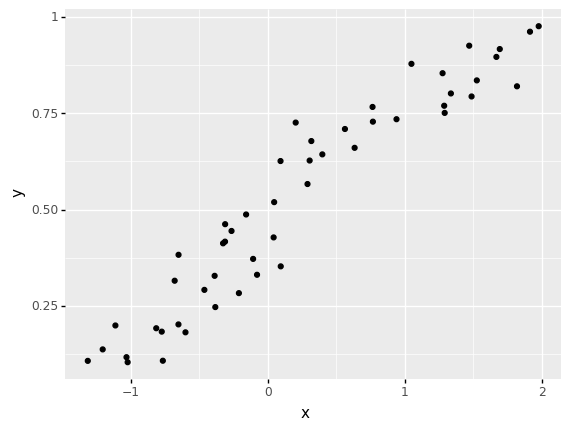

<ggplot: (8729341192789)>

In [24]:

## generate some 2d rounded data
# x = dist.Normal(0,1).sample(PRNGKey(10), (100,))
Nobs = 50
x = np.random.normal(0, 1, Nobs)
y_p = scipy.special.expit(-.3 + 1.5*x)
y_raw = np.random.beta(y_p*20, (1-y_p)*20, Nobs)
y_round = jnp.round(y_raw*10).astype("int32")

pd.DataFrame({"x":x,"y":y_raw}) >> ggplot(aes(x="x",y="y")) + geom_point()
# X_raw = dist.Beta(.75*10, (1-.75)*10).sample(PRNGKey(10), (100,))

# x_round


In [27]:
def betacdf(alpha, beta, x):
    vals = jnp.linspace(1e-5, 1.-1e-5, num=5_000)
    probs = jnp.exp(dist.Beta(alpha, beta).log_prob(vals))
    # then sum up probs below x 
    validprobs = jnp.where(vals <= x, probs, 0.)
    
    return jnp.sum(validprobs/5_000.)


betacdf = jax.vmap(jax.vmap(betacdf, (0, 0, 0)), (None,None,1))

def f2(mu, k):
    a = mu*k
    b = (1.-mu)*k
    
    responses = jnp.linspace(0,10, num=11)
    responses = jnp.broadcast_to(responses, (mu.shape[0], responses.shape[0]))
    lower = jnp.clip((responses/10.) - .05, 0., 1.)
    upper = jnp.clip((responses/10.) + .05, 0., 1.)

    prob_resps = betacdf(a, b, upper) - betacdf(a, b, lower) # needs to be (n, 11)
    
    return(prob_resps)


def linmodel_round(x, y=None):
    alpha = numpyro.sample("alpha", dist.Normal(0,5))
    beta = numpyro.sample("beta", dist.Normal(0,1))

    mu = expit(alpha + beta*x)
    k = numpyro.sample("k", dist.HalfCauchy(10)) # noise parameter

    resp_probs = jnp.transpose(f2(mu,k)) # possibly renormalize
    
    with numpyro.plate("data", y.shape[0]):

        yhat = numpyro.sample("yhat", dist.Categorical(probs=resp_probs), obs=y)
        # yhat = numpyro.sample("yhat", dist.Beta(mu*k, (1-mu)*k), obs=y)

In [ ]:
kernel = NUTS(linmodel_round, target_accept_prob=.80)

mcmc = MCMC(kernel, 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=1)

mcmc.run(random.PRNGKey(0), x, y_round)

warmup:  33%|███▎      | 655/2000 [13:47<21:17,  1.05it/s, 15 steps of size 3.15e-06. acc. prob=0.78]    

In [ ]:
mcmc.print_summary()

not sampling very well ... 

In [304]:
# betacdf2(np.ones(2), np.ones(2), np.array([[.25, .5, .75], [.25,.5,.75]]))

# np.broadcast_to(np.ones(3), (2,3))
# vals = jnp.linspace(jnp.ones(3)*1e-5, jnp.ones(3)*1.-1e-5, num=10)
# vals.shape, np.array([[.25, .5, .75], [.25,.5,.75]]).shape
# jnp.exp(dist.Beta(np.ones(3)*3, np.ones(3)*3).log_prob(vals))
# jnp.sum(probs/10000., axis=0)
# x = np.array([[.25, .5, .75], [.25,.5,.75]])
# alpha = np.ones(2)
# beta = np.ones(2)
# N = alpha.shape[0]
# vals = jnp.linspace(1e-5, 1.-1e-5, num=10)
# np.broadcast_to(x, (x.shape[0], vals.shape[9])
# probs = dist.Beta(alpha, beta).log_prob(vals)
# jnp.where(vals <= , probs, 0.)

# def betacdf2(alpha, beta, x):
#     # assume alpha, beta have length of N
#     # x.shape = (N, z)
#     N = alpha.shape[0]
#     vals = jnp.linspace(jnp.ones(N)*1e-5, jnp.ones(N)*1.-1e-5, num=10)
#     probs = jnp.exp(dist.Beta(alpha, beta).log_prob(vals))
#     # then sum up probs below x 
#     validprobs = jnp.where(vals <= x, probs, 0.)
    
#     return jnp.sum(validprobs/10000.) # output shape is (N, z)

# betacdf2(np.ones(2), np.ones(2), np.array([[.25, .5, .75], [.25,.5,.75]]).T)
# vals.shape
# probs = jnp.exp(dist.Beta(alpha, beta).log_prob(vals))
# then sum up probs below x 
# validprobs = jnp.where(vals <= x, probs, 0.)


# def betacdf(alpha, beta, x):
#     vals = jnp.linspace(1e-5, 1.-1e-5, num=10000)
#     probs = jnp.exp(dist.Beta(alpha, beta).log_prob(vals))
#     # then sum up probs below x 
#     validprobs = jnp.where(vals <= x, probs, 0.)
    
#     return jnp.sum(validprobs/10000.)

# betacdf = jax.vmap(jax.vmap(betacdf, (0, 0, 0)), (None,None,1))
# betacdf(np.ones(2), np.ones(2), np.array([[.25, .5, .75], [.25, .5, .75]]))

## works
# xyz =jax.vmap(betacdf, (0, 0, 0))#(3, 3, np.array([.25, .5, .75]))
# jax.vmap(xyz, (None, None, 1))(np.ones(2), np.ones(2), np.array([[.25, .5, .75], [.25, .5, .75]]))


# f2(np.array([.5, .5, .75]), np.array([5, 10, 15]))
# jnp.ones(11).shape, jnp.linspace(0,10, num=11).shape
# mu = np.ones(2)*.5
# k = np.ones(2)*10

# a = mu*k
# b = (1.-mu)*k

# responses = jnp.linspace(0,10, num=11)
# responses = jnp.broadcast_to(responses, (mu.shape[0], responses.shape[0]))

# lower = jnp.clip((responses/10.) - .05, 0., 1.)
# upper = jnp.clip((responses/10.) + .05, 0., 1.)

# prob_resps = betacdf(a, b, upper) - betacdf(a, b, lower)

# prob_resps.T.shape

# dist.CategoricalProbs(probs=jnp.array([.25,.5,.25])).sample(PRNGKey(0), (11,))
# dist.CategoricalProbs(probs=jnp.array([[.25,.5,.25],[.25,.5,.25],[.25,.5,.25],[.25,.5,.25] ])).log_prob(jnp.array([0,1,2,0]))

# jnp.array([[.25,.5,.25],[.25,.5,.25],[.25,.5,.25],[.25,.5,.25] ]).shape

ValueError: Incompatible shapes for broadcasting: ((1, 3), (1, 3), (3, 11))


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.32      0.05     -0.32     -0.40     -0.23   1042.97      1.00
      beta      1.47      0.07      1.47      1.35      1.58    934.76      1.00
         k     17.39      2.29     17.32     13.52     20.95    800.06      1.00

Number of divergences: 0
